<h1><center>CIS434 Social Media</center></h1>
<h1><center>Final Project Report</center></h1>
<center>Fangyuan (Milar) Liu</center>
<center>31637503</center>

## Introduction

The dataset provided for this project is the tweets sent by a customer to an airline, extracted from twitter. Most of the tweets are negative. The goal of this project is to identify those tweets that are NOT negative. 

In order to achieve the goal, the following steps are conducted, including .

Throughout all the steps, the output will be generated as:
* a CSV file of non-negative tweets consisting of three columns:
* * column 1: id from the original table corresponding to the tweet
* * column 2: the evaluation of whether the classification is correct (1 being correct, 0 being wrong)
* * column 3: contents of the identified non-negative tweets

## 1. Data cleaning and visualization

#### 1.1 Import the packages for further steps

In [1]:
# packages for data handling
import re
import pandas as pd 
import numpy as np 
# packages for visualization
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
# packages for pre-processing and text handling
import string
import nltk
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# packages for model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# packages for ignoring unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

#### 1.2 Load the training and testing dataset
Load the training dataset and label the noncomplaint tweets as 1, and the complaint ones as 0, combine them together. Also load the test dataset and label the tweets as NaN for further processing. There are 1700 obs of non-negative training data and 1700 obs of negative training data. The testing data includes 4555 unlabeled obs.

In [2]:
train_pos = pd.read_csv('noncomplaint1700.csv')
train_pos['label'] = 1
train_neg = pd.read_csv('complaint1700.csv')
train_neg['label'] = 0
train = pd.concat([train_pos, train_neg])
test = pd.read_csv('temp.csv')[['id', 'airline', 'tweet']]
test['label'] = np.nan

#### 1.3 Clean the datasets
Firstly, combine the training and testing dataset for pre-processing together. Then, define the function remove_pattern( ) to remove the "@user", which is unnecessary for the analysis. Also, remove the numbers and special characters, which are also unnecessary. Secondly, tokenize all the tweets in the combined dataset. Thridly, stemming the tweets context. For instance, the words "playing, player, played" will all be regarded as the root word "play".

In [3]:
combi = train.append(test, ignore_index=True)
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt  
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [4]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [The, best, summertime, soap, opera, is, back,...
1    [yes, the, change, fees, are, cheaper, seems, ...
2    [Do, you, guys, not, fly, from, Birmingham, to...
3    [This, mornings, #flight, seems, to, be, on, t...
4    [I, have, never, been, to, #Boston, Would, lov...
Name: tidy_tweet, dtype: object

In [5]:
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

#### 1.4 Learn about the keywords
Use wordcloud to plot the frequently used words, to learn about the tweets content. As we can see, the keywords include: flight, plane, delay, airline, time, cancel, customerservice, etc. The wordcloud gives a general idea of users' sentiments distribution in the datasets.

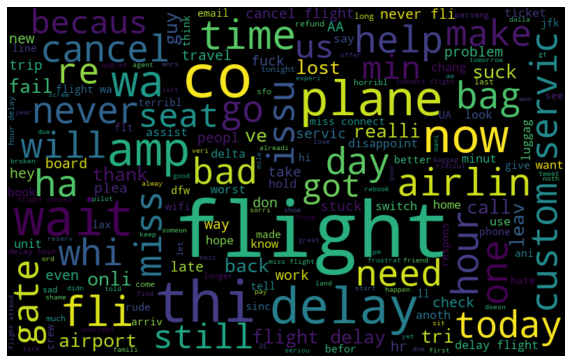

In [6]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## 2. Feature extraction

#### 2.1 Use bag-of-word (bow) for featuring

In [7]:
# bag-of-word
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

#### 2.2 Use TF-IDF for featuring

In [8]:
# tfidf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

#### 2.3 Split the featured data into training and testing datasets
As mentioned, there are 3400 obs in the training dataset (1700 non-negative obs and 1700 negative obs), and 4555 obs in testing dataset. In addition, build a dataframe called "res" to store the results of models.

In [9]:
train_bow = bow[:3400,:]
test_bow = bow[3401:,:]

In [10]:
X_train=tfidf[0:3400,:]
y_train=combi['label'].loc[0:3399]
X_test=tfidf[3400:,:]

In [11]:
res = combi.loc[3400:,]
res

,id,airline,tweet,label,tidy_tweet
3400,17,VirginAmerica,Ive flown @VirginAmerica @USAirways and @Delta...,NaN,ive flown and in the last day amp delta wa the...
3401,169,JetBlue,@JetBlue my luggage was lost on your flight fr...,NaN,my luggag wa lost on your flight from bo to dc...
3402,173,SouthWest,@SouthwestAir I'm on a plane to Austin that is...,NaN,I m on a plane to austin that is go land in da...
3403,233,VirginAmerica,lol RT @IIJERiiCHOII: Someone fucking called i...,NaN,lol RT someon fuck call in to pretend to be me...
3404,249,VirginAmerica,@IIJERiiCHOII @VirginAmerica fucking 10/10,NaN,fuck
...,...,...,...,...,...
7950,173468,Delta,@DeltaAssist I'm currently booked on DL743. I'...,NaN,I m current book on DL I ll miss my connect un...
7951,173496,United,Yo real talk fuck you @united you guys have de...,NaN,Yo real talk fuck you you guy have delay my fl...
7952,173532,JetBlue,@JetBlue Why is it more difficult to rebook a ...,NaN,whi is it more difficult to rebook a flight wi...
7953,173605,Delta,@DeltaAssist 4th cancelled flight of the weeke...,NaN,th cancel flight of the weekend for me could u...


## 3. Model building
To classify the testing tweets into non-negative ones and negative ones, build 6 different models, which are:
* Naive Bayes (NB)
* Support vector machine (SVM)
* * polynomial kernel
* * rbf kernel
* Bagging
* Boosting
* Logistic regression
* Random forest

Specifically, for the models need to decide parameters (SVM, LR, RF), use GridSearchCV to find the best parameters and best estimators for the model. 

Since it can be quite arbitrary to directly classify the obs as non-negative (1) and negative (0), it's better to check the probability that each prediction being 1 or 0, learn about the probabilities, and then, set appropriate threshold to tune the predictions accordingly.

For each model, a list is created to store the predictions generated by this model.

#### 3.1 Naive Bayes (NB)
Having used .predict_proba( ) to check the prabablity of classification, the output shows that most of the probabilities centralize around 0.33. Hence, it should be better to set the threshold to 0.33 rather than the default value 0.5. By setting the threshold as 0.33, if the probability to label 0 is greater than 0.33, the obs will be classified as negative, otherwise it will be classified as non-negative.

In [12]:
NB = MultinomialNB().fit(X_train, y_train)

In [13]:
NB_neg = NB.predict_proba(X_test)[:,0]
NB_pred = []
for i in range(0, len(NB_neg)):
    if NB_neg[i] > 0.33:
        NB_pred.append(0)
    else:
        NB_pred.append(1)

In [14]:
res['NB_pred'] = NB_pred

#### 3.2 Support vector machine (SVM)
For SVM models using polynomial and rbf kernel, use GridSearchCV to find out the best parameters and best estimators. As same logic mentioned above, the threshold of SVM model is set as 0.4 to make the classification more effective.

In [15]:
# kernel=poly
SVM_poly = SVC(kernel='poly', probability=True)
param_grid = {'C': [0.1,1,10,100], 'gamma': [0.01,0.1,1],'degree': [2,3,5]} 
grid_search = GridSearchCV(SVM_poly, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='poly', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 5],
                         'gamma': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'C': 1, 'degree': 2, 'gamma': 1}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [17]:
SVM_poly_neg = grid_search.predict_proba(X_test)[:,0]
SVM_poly_pred = []
for i in range(0, len(SVM_poly_neg)):
    if SVM_poly_neg[i] > 0.4:
        SVM_poly_pred.append(0)
    else:
        SVM_poly_pred.append(1)

In [18]:
res['SVM(poly) pred'] = SVM_poly_pred

In [19]:
# kernel-rbf
SVM_rbf = SVC(kernel='rbf', probability=True)
param_grid = {'C': [0.1,1,10,100], 'gamma': [0.01,0.1,1],'degree': [2,3,5]} 
grid_search = GridSearchCV(SVM_rbf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 5],
                         'gamma': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'C': 10, 'degree': 2, 'gamma': 0.01}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [21]:
SVM_rbf_neg = grid_search.predict_proba(X_test)[:,0]
SVM_rbf_pred = []
for i in range(0, len(SVM_rbf_neg)):
    if SVM_rbf_neg[i] > 0.4:
        SVM_rbf_pred.append(0)
    else:
        SVM_rbf_pred.append(1)

In [22]:
res['SVM(rbf) pred'] = SVM_rbf_pred

#### 3.3 Bagging
For bagging model, as same logic mentioned above, the threshold of bagging model is set as 0.4 to make the classification more effective.

In [23]:
dtc = DecisionTreeClassifier(criterion="entropy")
bagging = BaggingClassifier(base_estimator=dtc, n_estimators=100, bootstrap=True)
bagging = bagging.fit(X_train,y_train)

In [24]:
bagging_neg = bagging.predict_proba(X_test)[:,0]
bagging_pred = []
for i in range(0, len(bagging_neg)):
    if bagging_neg[i] > 0.4:
        bagging_pred.append(0)
    else:
        bagging_pred.append(1)

In [25]:
res['Bagging pred'] = bagging_pred

#### 3.4 Boosting
For boosting model, as same logic mentioned above, the threshold of boosting model is set as 0.495 to make the classification more effective.

In [26]:
boosting = AdaBoostClassifier(n_estimators=100, learning_rate=1)
boosting = boosting.fit(X_train, y_train)

In [27]:
boosting_neg = boosting.predict_proba(X_test)[:,0]
boosting_pred = []
for i in range(0, len(boosting_neg)):
    if boosting_neg[i] > 0.495:
        boosting_pred.append(0)
    else:
        boosting_pred.append(1)

In [28]:
res['Boosting pred'] = boosting_pred

#### 3.5 Logistic regression (LR)
For LR model, use GridSearchCV to find out the best parameters and best estimators. As same logic mentioned above, the threshold of LR model is set as 0.4 to make the classification more effective.

In [29]:
LR = LogisticRegression(random_state=1)
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
grid_search = GridSearchCV(LR, param_grid,cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [30]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'C': 1.0, 'penalty': 'l2'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [31]:
LR_neg = grid_search.predict_proba(X_test)[:,0]
LR_pred = []
for i in range(0, len(LR_neg)):
    if LR_neg[i] > 0.4:
        LR_pred.append(0)
    else:
        LR_pred.append(1)

In [32]:
res['LR pred'] = LR_pred

#### 3.6 Random forest (RF)
For RF model, use GridSearchCV to find out the best parameters and best estimators. As same logic mentioned above, the threshold of RF model is set as 0.41 to make the classification more effective.

In [33]:
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,500,1000], 'max_features': [5,15,25],'max_depth':[5,10,20,50]} 
grid_search = GridSearchCV(RF, param_grid,cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [34]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 50, 'max_features': 5, 'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [66]:
RF_neg = grid_search.predict_proba(X_test)[:,0]
RF_pred = []
for i in range(0, len(RF_neg)):
    if RF_neg[i] > 0.411:
        RF_pred.append(0)
    else:
        RF_pred.append(1)

In [67]:
res['RF pred'] = RF_pred

## 4. Model results and selection
To display the results of the above models, create a dataframe with the first column showing the names of models, the second column showing the predicted number of non-negative tweets.

In [68]:
models_res = pd.DataFrame()
models_res['Model name'] = ['NB', 'SVM(poly)', 'SVM(rbf)', 'Bagging', 'Boosting', 'LR', 'RF']
models_res['# of non-negative tweets'] = [sum(NB_pred), 
                                         sum(SVM_poly_pred), sum(SVM_rbf_pred), 
                                         sum(bagging_pred), 
                                         sum(boosting_pred), 
                                         sum(LR_pred), 
                                         sum(RF_pred)]
models_res

,Model name,# of non-negative tweets
0,NB,321
1,SVM(poly),938
2,SVM(rbf),988
3,Bagging,1109
4,Boosting,294
5,LR,824
6,RF,275


As can be seen in the above chart, the number of non-negative tweets predicted by NB, boosting model, and RF make more sense than the others, given that the project information says most of the obs are negative. To look into details and compare these three models, extract their results as a CSV file named "models_comparison.csv", and screen the non-negative tweets predicted by each model using manual judgement.

In [38]:
models_comparison = test

In [39]:
models_comparison['Boosting_pred'] = boosting_pred
models_comparison['RF_pred'] = RF_pred
models_comparison['NB_pred'] = NB_pred
models_comparison

,id,airline,tweet,label,Boosting_pred,RF_pred,NB_pred
0,17,VirginAmerica,Ive flown @VirginAmerica @USAirways and @Delta...,NaN,0,0,0
1,169,JetBlue,@JetBlue my luggage was lost on your flight fr...,NaN,0,0,0
2,173,SouthWest,@SouthwestAir I'm on a plane to Austin that is...,NaN,0,0,0
3,233,VirginAmerica,lol RT @IIJERiiCHOII: Someone fucking called i...,NaN,0,0,0
4,249,VirginAmerica,@IIJERiiCHOII @VirginAmerica fucking 10/10,NaN,0,0,0
...,...,...,...,...,...,...,...
4550,173468,Delta,@DeltaAssist I'm currently booked on DL743. I'...,NaN,0,0,0
4551,173496,United,Yo real talk fuck you @united you guys have de...,NaN,0,0,0
4552,173532,JetBlue,@JetBlue Why is it more difficult to rebook a ...,NaN,0,0,0
4553,173605,Delta,@DeltaAssist 4th cancelled flight of the weeke...,NaN,0,0,0


In [40]:
models_comparison.to_csv(r'models_comparison.csv')

After comparing the three models, the RF model tends to predict more accurately. Select RF as the model to use.
Details will be provided in the following part.

## 5. Output generation

#### 5.1 Screen the predictions of RF model
Use the CSV file extracted above, for the non-negative tweets predicted by each models, screen the tweets with manual judgement by putting myself in the shoes of the tweeting customer. Calculate the precisions for each model's classification, and the highest one is from RF model.

Create a dataframe to display the results. The column "evaluation" representing the evaluation of whether the classification is correct: 1 being correct, 0 being wrong. It is from the comparison of manual judgement and RF predictions.

In [41]:
df_output = pd.read_csv('RF_pred_pos.csv')
df_output = df_output[df_output['RF_pred']==1].iloc[:,1:]
df_output['label'] = df_output['label'].astype(int)
df_output

,id,airline,tweet,label,RF_pred
5,283,United,how in the heck am I supposed to watch @GUBLER...,0,1
10,591,VirginAmerica,"@mobiata hi guys, I saw you were missing @Virg...",1,1
24,1119,JetBlue,Super annoying that my 825 flight didn't leave...,1,1
38,1484,American,Can't wait to fly on @AmericanAir again. http:...,1,1
47,1941,VirginAmerica,@VirginAmerica Boston! I am flying there with ...,1,1
...,...,...,...,...,...
4425,168116,United,@ThisIsPVRIS @united tbh only ever hear bad th...,0,1
4427,168240,VirginAmerica,Thanks @VirginAmerica for the smooth flight. I...,1,1
4462,169437,SouthWest,@bobakm @united @Delta @SouthwestAir look at y...,1,1
4471,169784,United,@xcanuck @united @cbcasithappens @SarahBlackwo...,0,1


#### 5.2 Generate the output CSV file
Create the final output dataframe with the required three columns and extract it as the required CSV file.

In [42]:
output = df_output[['id', 'label', 'tweet']]
output.reset_index(inplace=True)
output.drop(columns = ['index'], inplace=True)
output.columns = ['id', 'evaluation', 'non-negative tweets']
output

,id,evaluation,non-negative tweets
0,283,0,how in the heck am I supposed to watch @GUBLER...
1,591,1,"@mobiata hi guys, I saw you were missing @Virg..."
2,1119,1,Super annoying that my 825 flight didn't leave...
3,1484,1,Can't wait to fly on @AmericanAir again. http:...
4,1941,1,@VirginAmerica Boston! I am flying there with ...
...,...,...,...
267,168116,0,@ThisIsPVRIS @united tbh only ever hear bad th...
268,168240,1,Thanks @VirginAmerica for the smooth flight. I...
269,169437,1,@bobakm @united @Delta @SouthwestAir look at y...
270,169784,0,@xcanuck @united @cbcasithappens @SarahBlackwo...


In [69]:
output.to_csv(r'fangyuan_liu.csv', index=False)

#### 5.3 Calculate the precision of classification
According to the definition, precision is calculated by first summing up the second column "evaluation" and then dividing the sum by the total number of rows, which is exactly the mean of second column "evaluation". 

Calculatioin shows that, the precision of classification is around:

__<mark style="background-color: yellow">0.74</mark>__.

In [44]:
Precision = output.mean()['evaluation']
print('The precision of classification is:', round(Precision, 2))

The precision of classification is: 0.74


## 6. Conclusion and discussion

This project builds and selects model to identify the non-negative and negative tweets on twitter towards the airlines. The results can be used by the airlines to better understand:
* the key issues to solve
* the market trend (consumers' preference among the market players)
* the opportunities for improvement

By taking advantage of this model, airlines can improve the service, try to fix the problems, better satisfy the consumers, and improve the revenue.

However, there are still some limitations of this project. One is the limited number of models built due to time and computer capability constraints. There are still many other models worth trying and may generate more accurate classifications, such as neural network. Another one may be the accuracy of training dataset. Looking into the training dataset and screening the tweets manually, some of them are classified wrongly, which lower the accuracy of predictions. With more accurate training datasets, the output may be better.

Many lessons are learned from the final project. Still a long way to go in social media analytics.